In [1]:
import warnings
warnings.simplefilter(action="ignore")

from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn.inspection import permutation_importance

plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

In [2]:
df = pd.read_csv("employee_retention_data.csv")

In [3]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [5]:
df['company_id'] = df['company_id'].astype('category')
df['quit_date'] = pd.to_datetime(df['quit_date'])
df['join_date'] = pd.to_datetime(df['join_date'])
df['length'] = (df['quit_date'] - df['join_date']).apply(lambda x: x.days)
df['weekofyear'] = df['quit_date'].dt.week
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,weekofyear
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0


# Create a headcount table

In [6]:
df_melt = pd.melt(
    df,
    id_vars=["employee_id", "company_id"],
    value_vars=["join_date", "quit_date"],
    var_name="action",
    value_name="date",
)
df_melt = df_melt.dropna()
df_melt['change'] = np.where(df_melt['action'] == 'join_date', 1, -1)

In [7]:
daily_change = df_melt.groupby(['date','company_id'])['change'].sum().reset_index()
daily_change.head()

,date,company_id,change
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [8]:
date_range = pd.DataFrame(pd.date_range('2011/01/24','2015/12/13'),columns=['date'])
company_range = pd.DataFrame(df['company_id'].unique(),columns=['company_id'])
date_range['key'] = 1
company_range['key'] = 1
headcount = date_range.merge(company_range,on='key')
headcount = headcount.drop(columns='key')
headcount.head()

,date,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


In [9]:
headcount = headcount.merge(daily_change,on=['date','company_id'],how='left')
headcount['change'] = headcount['change'].fillna(0)
headcount.head(10)

,date,company_id,change
0,2011-01-24,7,1.0
1,2011-01-24,4,12.0
2,2011-01-24,2,17.0
3,2011-01-24,9,3.0
4,2011-01-24,1,25.0
5,2011-01-24,6,3.0
6,2011-01-24,10,0.0
7,2011-01-24,5,5.0
8,2011-01-24,3,9.0
9,2011-01-24,8,6.0


In [10]:
headcount['employee_headcount'] = headcount.groupby('company_id')['change'].cumsum()
headcount.head(10)

,date,company_id,change,employee_headcount
0,2011-01-24,7,1.0,1.0
1,2011-01-24,4,12.0,12.0
2,2011-01-24,2,17.0,17.0
3,2011-01-24,9,3.0,3.0
4,2011-01-24,1,25.0,25.0
5,2011-01-24,6,3.0,3.0
6,2011-01-24,10,0.0,0.0
7,2011-01-24,5,5.0,5.0
8,2011-01-24,3,9.0,9.0
9,2011-01-24,8,6.0,6.0


# Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Length')

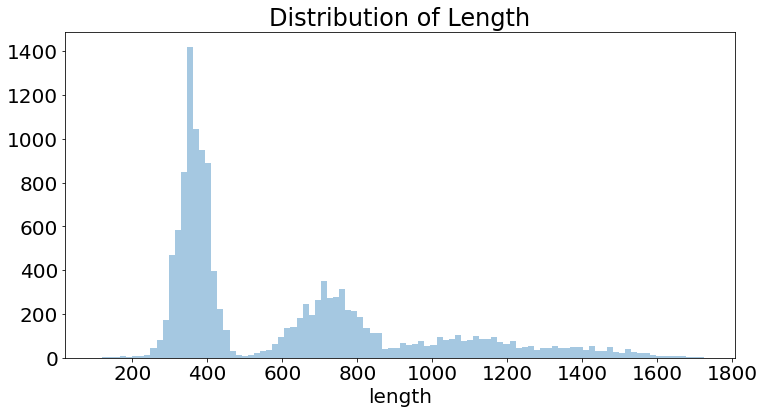

In [11]:
sns.distplot(df['length'],bins=100, kde=False)
plt.title('Distribution of Length')

Text(0.5, 1.0, 'Distribution of Quit Week in a Year')

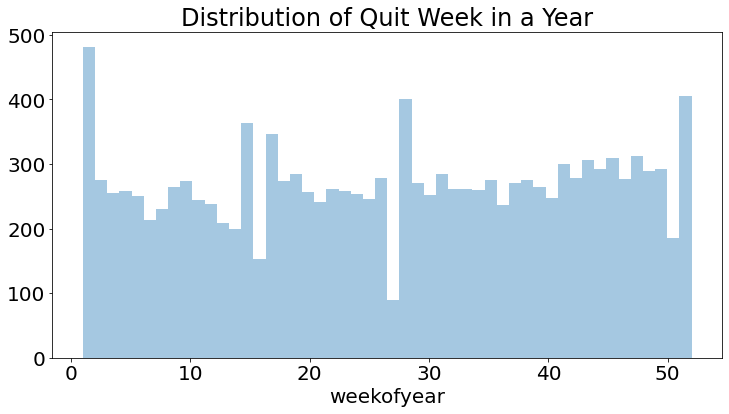

In [12]:
sns.distplot(df['weekofyear'],bins=50, kde=False)
plt.title('Distribution of Quit Week in a Year')

There are peaks around each employee year anniversary and around the new year. Makes sense, companies have much more money to hire at the beginning of the year.

Looking at the histogram of employment length, it looks like we could define early quitters as those people who quit within 1 yr or so. So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current company for at least 13 months, we remove them).


In [13]:
df = df[df.join_date < '2014/11/13'] # only keep people who had enough time to age
df['early_quitter'] = np.where(df['length'] < 396, 1, 0)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,weekofyear,early_quitter
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,NaN,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0


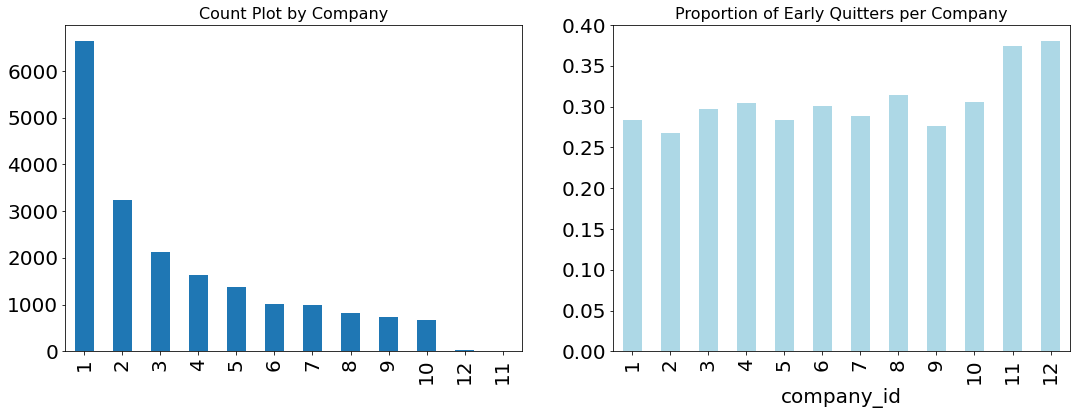

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df['company_id'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot by Company', fontsize=16)
df.groupby('company_id')['early_quitter'].mean().plot(kind='bar',ax=ax[1],color="lightblue")
ax[1].set_title('Proportion of Early Quitters per Company', fontsize=16)
#plt.tight_layout()
plt.show()

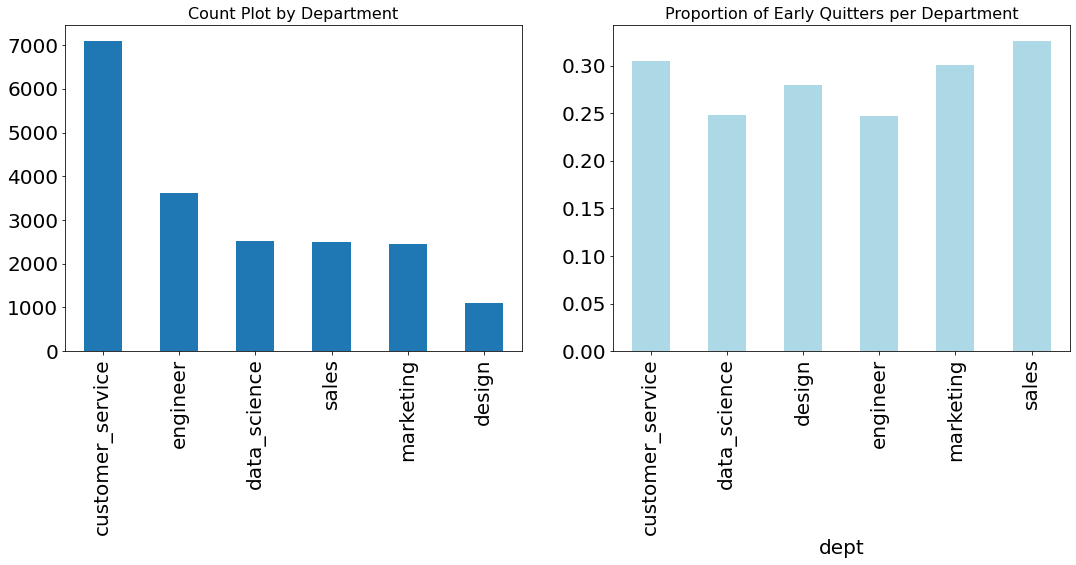

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
df['dept'].value_counts().plot(kind='bar',ax=ax[0])
ax[0].set_title('Count Plot by Department', fontsize=16)
df.groupby('dept')['early_quitter'].mean().plot(kind='bar',ax=ax[1],color="lightblue")
ax[1].set_title('Proportion of Early Quitters per Department', fontsize=16)
#plt.tight_layout()
plt.show()

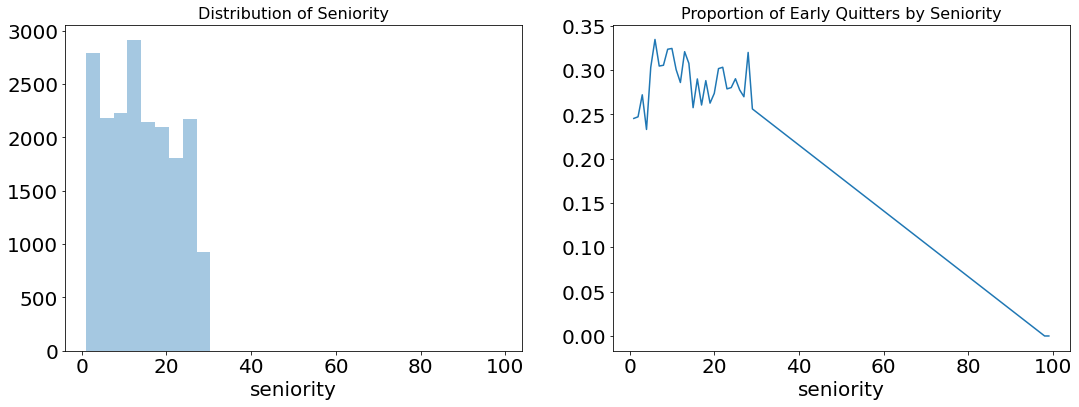

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df['seniority'],bins=30, kde=False, ax=ax[0])
ax[0].set_title('Distribution of Seniority', fontsize=16)
df.groupby('seniority')['early_quitter'].mean().plot(ax=ax[1])
ax[1].set_title('Proportion of Early Quitters by Seniority', fontsize=16)
#plt.tight_layout()
plt.show()

In [17]:
df[df['seniority'] > 30]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,weekofyear,early_quitter
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123.0,2.0,0
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06,864.0,49.0,0


We notice that there are only two abnormal records with seniority greater than 30. We can remove these two rows.

In [18]:
df = df[df['seniority'] < 30]

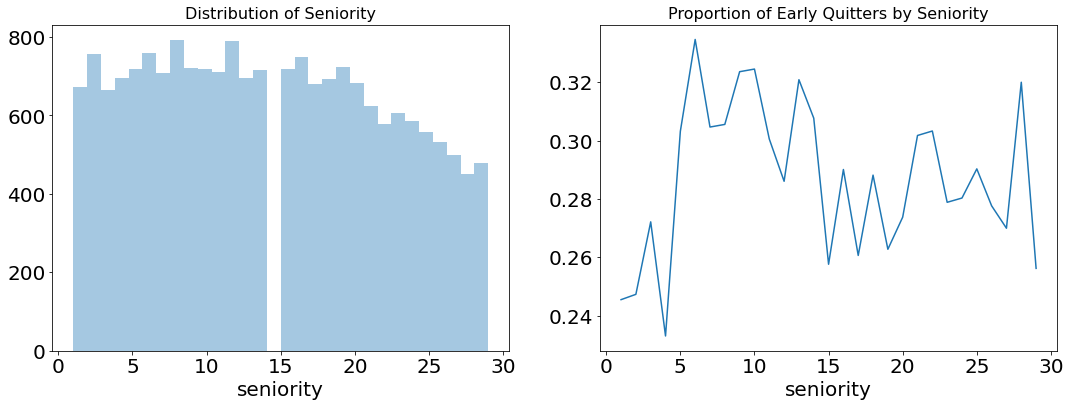

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df['seniority'],bins=30, kde=False, ax=ax[0])
ax[0].set_title('Distribution of Seniority', fontsize=16)
df.groupby('seniority')['early_quitter'].mean().plot(ax=ax[1])
ax[1].set_title('Proportion of Early Quitters by Seniority', fontsize=16)
#plt.tight_layout()
plt.show()

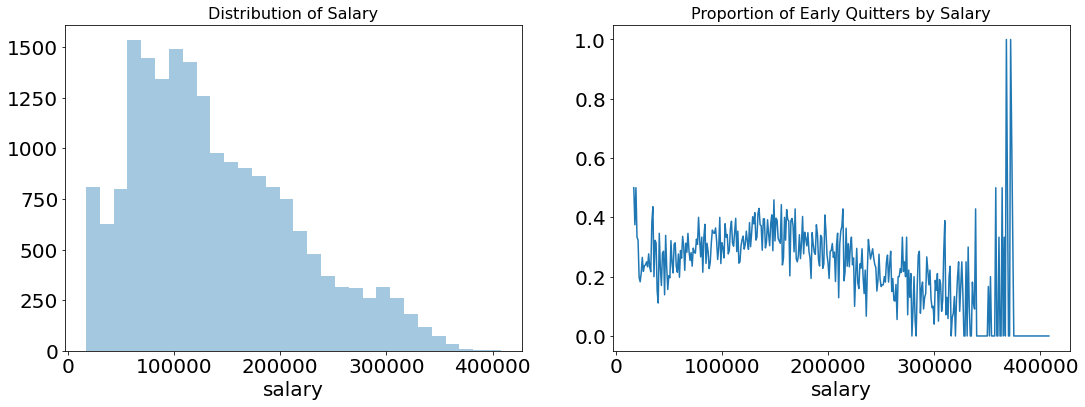

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df['salary'],bins=30, kde=False, ax=ax[0])
ax[0].set_title('Distribution of Salary', fontsize=16)
df.groupby('salary')['early_quitter'].mean().plot(ax=ax[1])
ax[1].set_title('Proportion of Early Quitters by Salary', fontsize=16)
#plt.tight_layout()
plt.show()

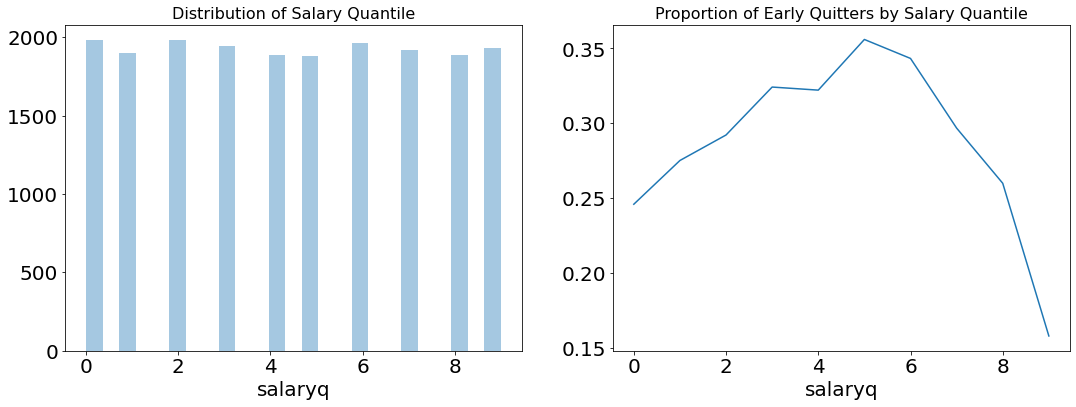

In [21]:
df['salaryq'] = pd.qcut(df['salary'], 10, labels=False)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df['salaryq'], kde=False, ax=ax[0])
ax[0].set_title('Distribution of Salary Quantile', fontsize=16)
df.groupby('salaryq')['early_quitter'].mean().plot(ax=ax[1])
ax[1].set_title('Proportion of Early Quitters by Salary Quantile', fontsize=16)
#plt.tight_layout()
plt.show()

<AxesSubplot:>

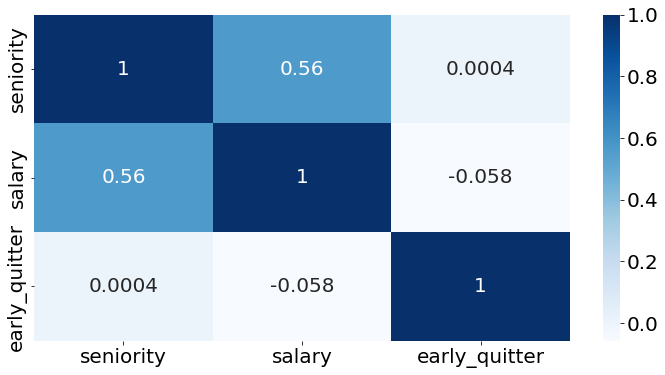

In [22]:
corr_plot = df[['seniority','salary','early_quitter']].corr()
sns.heatmap(corr_plot, annot = True, xticklabels = True, yticklabels = True,cmap = "Blues")

Salary and seniority is 56% correlated, which means that higher seniority tend to earn more money.

# Machine Learning

Let’s now build a simple decision tree model. Here we can just care about: seniority, salary, dept and company.

In [23]:
X = df[['company_id','dept','seniority','salary']]
X = pd.get_dummies(X,drop_first=True)
y = df['early_quitter']

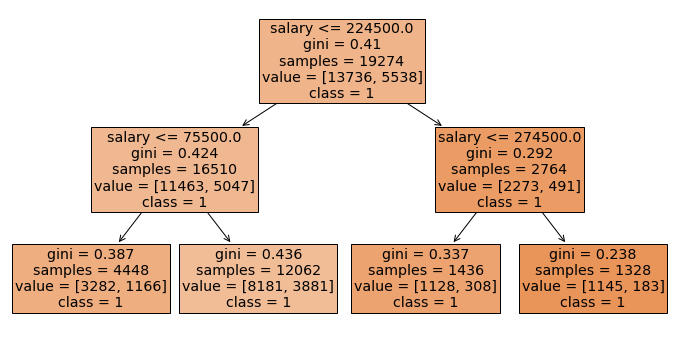

In [24]:
clf = tree.DecisionTreeClassifier(max_depth=2).fit(X, y)
fig = tree.plot_tree(clf, feature_names=X.columns, class_names=["1", "2"], filled=True)

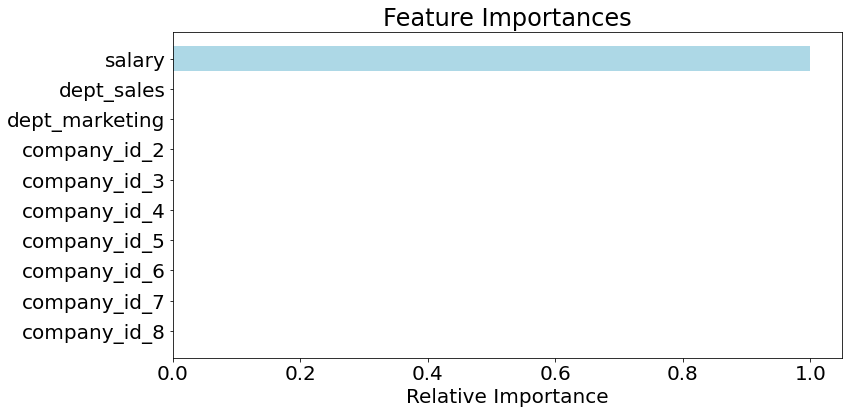

In [25]:
importances = clf.feature_importances_
indices = np.argsort(importances)
num_features = 10 
features = X.columns.tolist()
plt.title('Feature Importances')
plt.barh(range(num_features), importances[indices[-num_features:]], color = 'lightblue', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

We then build a XGBoost model with the same features and use grid search and 5-fold cross validation to tune hyperparameters.

In [26]:
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=10,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=1234,
).fit(X, y, verbose=True)

In [27]:
param_grid = {
    "max_depth": list(range(1, 3)),
    "n_estimators": list(range(10, 61, 10)),
}
scoring = {"AUC": "roc_auc"}

In [28]:
from sklearn.model_selection import GridSearchCV
clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=10
).fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [29]:
print(clf_cv.best_params_)
print(clf_cv.best_score_)

{'max_depth': 1, 'n_estimators': 50}
0.5696294420826484


In [30]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="lightblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

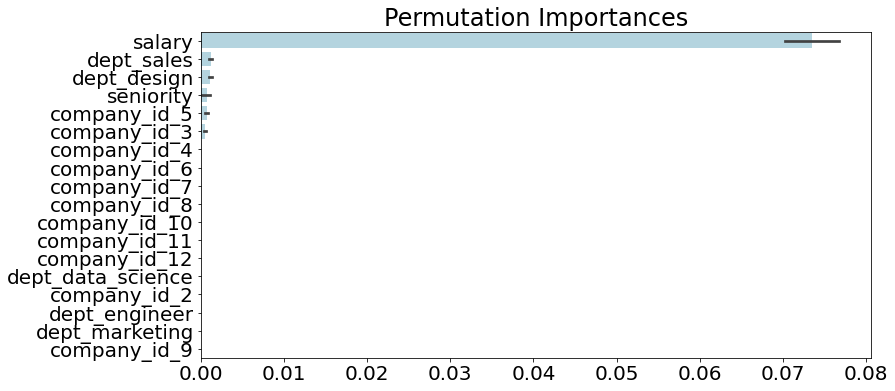

In [31]:
fig = importance(clf, X, y, X.columns)

Salary is what matters the most. After all, it probably has within it information about the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much all the information available.

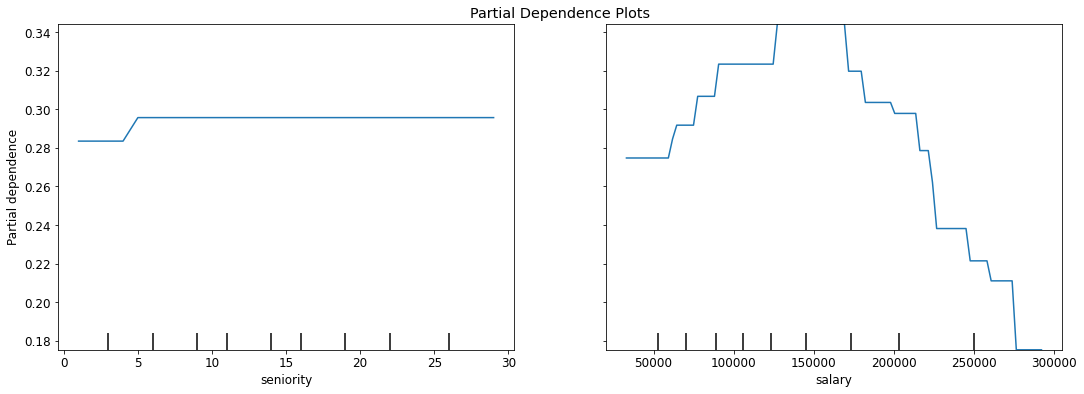

In [32]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
plt.rcParams.update({'font.size':12})
fig, ax = plt.subplots(figsize=(18,6))
ax.set_title("Partial Dependence Plots")
fig = PartialDependenceDisplay.from_estimator(clf, X, X.columns[:2], ax=ax)

From the partial dependence plot, we can tell that employees with relatively high or low salaries are less likely to churn, which aligns with the decision tree with 224,500 and 75,500 as split point.

# Conclusions

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.
2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.
3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.